In [1]:
import os
import shutil 
import sys

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split

from preprocess import preprocess
from roi_predict import get_most_activated_roi, get_rois
from test_train_val_split import ttv_split
from plotting_helpers import make_mesh, plotly_3d, plt_3d
import warnings
warnings.filterwarnings("ignore")

sys.path.append("../LIDC")
from unet_2d.model import unet_2d_res

Using TensorFlow backend.


# (1) Extract images NLST raw dataset

**Skip in ec2 – (done locally)**

data/nlst_extracted/121337/T0_2.tif


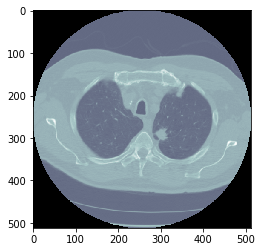

In [2]:
# visualize

pid_path = 'data/nlst_extracted/' + os.listdir('data/nlst_extracted')[np.random.randint(len(os.listdir('data/nlst_extracted')))]
im_path = pid_path + '/' + os.listdir(pid_path)[len(os.listdir(pid_path))-1]

img = imread(im_path) 
print(im_path)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.array(img), cmap='bone')
plt.show()

# (2) Remove missing image entries from table

In [3]:
# df = pd.read_csv('data/nlst_table_nc.csv')
df = pd.read_csv('data/nlst_table.csv')

df['kept'] = [
    os.path.isfile(f'data/nlst_extracted/{str(row.pid)}/{row.study_yr}_{str(row.sct_ab_num)}.tif')
    for _, row in df.iterrows()
] 

df_kept_pos = df[np.logical_and(df['kept']==1, df.recurrence == 1)]
df_kept_neg = df[np.logical_and(df['kept']==1, df.recurrence == 0)]


print(f"Number of kept 'recurrent' nodules: {len(df_kept_pos)}")
print(f"Number of kept 'recurrent' patients: {len(df_kept_pos.pid.unique())}\n")

print(f"Number of kept 'non-recurrent' nodules: {len(df_kept_neg)}")
print(f"Number of kept 'non-recurrent' patients: {len(df_kept_neg.pid.unique())}")

Number of kept 'recurrent' nodules: 212
Number of kept 'recurrent' patients: 89

Number of kept 'non-recurrent' nodules: 665
Number of kept 'non-recurrent' patients: 239


In [4]:
df = df[df.kept == 1]
df.to_csv('data/nlst_table_cleaned.csv', index=None)

# (3) Preprocess extracted images

*Note: bad lung field segmentations handled 'manually' in preprocessing*

In [5]:
# # 3.1: clear out old data
# if os.path.exists('data/nlst_processed'):
#     shutil.rmtree('data/nlst_processed')

In [6]:
# # 3.2: extract from raw
# preprocess('data/nlst_extracted', 'data/nlst_processed', table_path='data/nlst_table_cleaned.csv')

105142: T0_1.tif


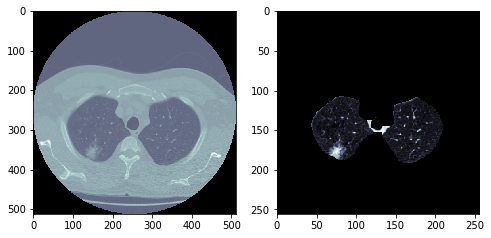

In [7]:
# 3.3: visualize

pid_idx = np.random.randint(len(os.listdir('data/nlst_processed')))
pid = os.listdir('data/nlst_processed')[pid_idx]
pid='105142'

img_idx = np.random.randint(len(os.listdir(f"data/nlst_processed/{pid}")))
img = os.listdir(f"data/nlst_processed/{pid}")[img_idx]

extract_path = f"data/nlst_extracted/{pid}/{img}"
processed_path = f"data/nlst_processed/{pid}/{img}"

print(pid + ": " + img)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.array(imread(extract_path) ), cmap='bone')
axs[1].imshow(np.array(imread(processed_path) ), cmap='bone')

plt.show()

# (4) Predict nodule segmentations and extract ROIs

In [8]:
# 4.1: load trained model

# MODEL_NAME = '../trained_segmentation_models/unet_lidc_curbest.hdf5'
MODEL_NAME = '../LIDC/unet_2d/best_proposed.hdf5'

model = unet_2d_res()
model.load_weights(MODEL_NAME)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# 4.2: clear out old data
if os.path.exists('data/nlst_rois_3d'):
    shutil.rmtree('data/nlst_rois_2d')
    shutil.rmtree('data/nlst_rois_3d')

In [10]:
# 4.3: predict segmentations and extract rois for all images
get_rois('data/nlst_extracted', 'data/nlst_processed', 'data/nlst_rois_2d', 'data/nlst_rois_3d', model)

Getting ROIs...8/328
No predicted ROI for 128899 T2_1.tif
Getting ROIs...26/328
No predicted ROI for 100697 T0_2.tif
Getting ROIs...29/328
No predicted ROI for 113176 T0_2.tif
Getting ROIs...31/328
No predicted ROI for 103359 T2_1.tif
Getting ROIs...36/328
No predicted ROI for 210653 T2_2.tif

No predicted ROI for 210653 T1_2.tif
Getting ROIs...51/328
No predicted ROI for 102660 T1_1.tif
Getting ROIs...59/328
No predicted ROI for 209119 T2_1.tif
Getting ROIs...105/328
No predicted ROI for 206359 T0_3.tif
Getting ROIs...110/328
No predicted ROI for 100954 T0_3.tif
Getting ROIs...163/328
No predicted ROI for 131657 T0_2.tif
Getting ROIs...180/328
No predicted ROI for 214923 T0_1.tif
Getting ROIs...184/328
No predicted ROI for 112506 T2_6.tif
Getting ROIs...230/328
No predicted ROI for 210419 T1_2.tif

No predicted ROI for 210419 T0_4.tif
Getting ROIs...257/328
No predicted ROI for 218510 T2_3.tif
Getting ROIs...278/328
No predicted ROI for 133545 T2_1.tif
Getting ROIs...308/328
No predic

207206: T0_4.tif


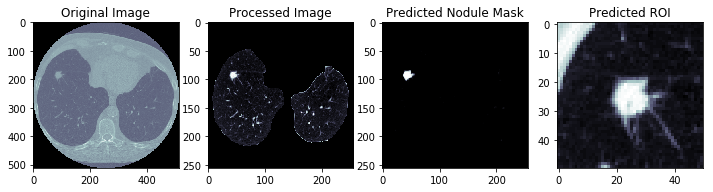

In [11]:
# 4.4: visualize

pid_idx = np.random.randint(len(os.listdir('data/nlst_rois_2d')))
pid = os.listdir('data/nlst_rois_3d')[pid_idx]
# pid = '100570'
# pid = '207954'
# pid = '215585'
# pid = '130162'
# pid = '106286'

img_idx = np.random.randint(len(os.listdir(f"data/nlst_rois_2d/{pid}")))
im = os.listdir(f"data/nlst_rois_2d/{pid}")[img_idx]

print(pid + ": " + im)

original_path = f"data/nlst_extracted/{pid}/{im}"
processed_path = f"data/nlst_processed/{pid}/{im}"
roi_path = f"data/nlst_rois_2d/{pid}/{im}"

prediction = model.predict(imread(processed_path).reshape(1, 256, 256, 1)/255).reshape(256, 256)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].imshow(np.array(imread(original_path)), cmap='bone')
axs[1].imshow(np.array(imread(processed_path)), cmap='bone')
axs[2].imshow(np.array(prediction), cmap='bone')
axs[3].imshow(np.array(imread(roi_path)), cmap='bone')

axs[0].set_title("Original Image")
axs[1].set_title("Processed Image")
axs[2].set_title("Predicted Nodule Mask")
axs[3].set_title("Predicted ROI")

    
plt.show()

In [12]:
pid=105142
im = 'T0_1.tif'
with open(f"data/nlst_rois_3d/{pid}/{im[:-4]}.pkl", "rb") as input_file:
    cube = pkl.load(input_file)
cube[cube < cube.max()/(3/2)] = 0
v, f = make_mesh(cube)
plotly_3d(v, f)

# (5) Split into Test and Train

In [13]:
# 5.1: clear out old data
if os.path.exists('data/nlst_train'):
    shutil.rmtree('data/nlst_train')
    shutil.rmtree('data/nlst_test')
    shutil.rmtree('data/nlst_val')

In [14]:
ttv_split()

No ROIs for 210653
No ROIs for 102660


In [15]:
# make an even amount for good batch size
for i in range(3):
    idxs = os.listdir('data/nlst_train/image_roi_3d/0')
    idx = idxs[np.random.randint(len(idxs))]
    
    for j in range(50):
        im_source = f'data/nlst_train/image_roi_3d/{j}/{idx}'
        im_dest = f'data/nlst_train/image_roi_3d/{j}/{len(idxs)+i}.tif'
    
        shutil.copyfile(im_source, im_dest)
    
    label_source = f'data/nlst_train/image_roi_3d/label/{idx}'
    label_dest =  f'data/nlst_train/image_roi_3d/label/{len(idxs)+i}.tif'
    shutil.copy(label_source, label_dest)